<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 1 - Logistic Regression Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 1: Malawi Poverty Prediction</h2> 

# Table of Contents

[Introduction](#introduction)  
&nbsp;&nbsp;&nbsp;[Explanation and Theory](#introduction-theory)  
&nbsp;&nbsp;&nbsp;[Considerations](#introduction-considerations)  
[Data Setup](#setup)  
&nbsp;&nbsp;&nbsp;[Feature Inspection and reduction](#features)  
&nbsp;&nbsp;&nbsp;[Multicollinearity](#multicollinearity)  
&nbsp;&nbsp;&nbsp;[Standardization](#standardization)  
[Statsmodels Logistic Regression](#statsmodels)  
&nbsp;&nbsp;&nbsp;[Fit Logit Model](#fit-logit)  
&nbsp;&nbsp;&nbsp;[Evaluate Logit Model](#eval-logit)  
[Scikit-Learn Logistic Regression](#sklearn-logreg)  
&nbsp;&nbsp;&nbsp;[Include All Features](#logreg-all-feats)  
&nbsp;&nbsp;&nbsp;[Include Sample Weights](#logreg-sample-weights)  
&nbsp;&nbsp;&nbsp;[Cross Validation](#cross-validation)  
&nbsp;&nbsp;&nbsp;[Parameter Tuning](#parameter-tuning)  
[Feature Selection](#feature-selection)  
&nbsp;&nbsp;&nbsp;[Feature Selection using Top-N Coefficients](#feature-selection-top-n)  
&nbsp;&nbsp;&nbsp;[Feature Selection with Iterative Elimination](#feature-selection-iterative)  
&nbsp;&nbsp;&nbsp;[Feature Selection using l1 Regularization](#feature-selection-l1)  
[Summary](#summary)

# Logistic Regression Classifier Introduction <a class="anchor" id="introduction"></a>

The first classifier we introduce in this series is the logistic regression classifier. Logistic regression is one of the most simple and well-known machine learning algorithms for binary classification. Despite its name, it is used for classification rather than regression. 

It basic terms, it predicts the probability of occurrence of an event by fitting the data to a logistic function. This probability is then translated into a class label based on the set threshold of the function.

## Explanation and Theory <a class="anchor" id="introduction-theory"></a>

**Assumptions and properties.** Going back to our initial example of binary classification from the Data Preparation notebook, we take a single question and plot the responses in the figure below. If we used linear regression, it would give us a straight line that best separates the poor from non-poor responses. However, we could not use this line to give us a probability, since it would give us a negative value for the responses near zero on the x-axis. Instead, when we use logistic regression, we fit this data with the logistic function:  

$$logistic(f(i))=\frac{1}{1+ e^{(-f(i))}}$$

The function transforms all input variables to the range [0,1], which brings the smallest or most negative numbers close to zero and the largest positive numbers close to one. This allows us to take real-valued inputs and output a probability of the input belonging to either class zero or one. We can then choose a threshold value, such as 0.5, and provide the class output.

<img alt="logistic function diagram" src="img/logistic-function.png"/>

**Algorithm and Training.** Logistic regression takes the form of a linear model:

$$f(i)=\beta_0+\beta_1x_{1,i}+...+\beta_mx_{m,i} $$

where $\beta_0,...,\beta_m$ are the regression coefficients or weights assigned to each feature $x$. For each data point $i$, a pseudo-variable $x_{0,i}=1$ is added to correspond to the intercept coefficient $\beta_0$. This allows us to write the model in vector form as:
$$f(i)=\boldsymbol{\beta}\cdot\boldsymbol{X_i}$$

When we train the logistic regression classifier, we are trying to find the best values of $\beta$ to match the data. This is done using an estimation method that attempts to minimize the error of the model. There are several techniques to do this, such as [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent).

## Considerations <a class="anchor" id="introduction-considerations"></a>

There are a few things to remember when using logistic regression as a classifier. First, it assumes that there is a linear relationship between the independent variables and the dependent variables. In high-dimensional datasets, this may not be the case, so logistic regression may not be the best choice of classifier.

Logisitic regression is also sensitive to highly correlated inputs. Having highly correlated inputs can cause the model to be overfit or will cause the model to fail to converge. We will take a closer look at how to deal with this issue in this notebook. 

# Data setup <a class="anchor" id="setup"></a>

First, we'll load a the libraries that will be used throughout this notebook. 

Note that we import a few custom libraries from this project. These contain functions that we have built for convenience to help make it easier to load and process the data and store the results of our models. A few of the functions we will introduce in this notebook have also been included in these libraries for use in the other notebooks.

Also note that we set the `COUNTRY` and `ALGORITHM_NAME` variables here. These are used to ensure we are loading in the correct data and storing our results in a standardized way.

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights)

ALGORITHM_NAME = 'lr'
COUNTRY = 'mwi'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In the pre-processing notebook we should have cleaned and organized the data already, so we should simply have to import our pre-processed files. For applying the algorithm, we'll need the features, weights, and labels. To make things more understandable for the analysis/evaluation, we'll also want to load the file that contains the questions associated with each feature.

Data to load: 
- mwi_train.pkl -> `X_train`, `y_train`, `w_train`
- mwi_questions.json -> `questions`

In [2]:
# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 9,183 rows and 484 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,hld_dwelloccu__Employer provides,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
hid,,,,,,,,,,,,,,,,,,,,,
304044580160,5,3,0.0,1.0,3,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
205205820123,3,2,1.0,3.0,1,1,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
102016880095,6,5,0.0,2.0,3,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
315356330210,3,3,3.0,3.0,1,1,1,3,1,0,...,1,1,0,0,0,0,0,0,1,1
313061660067,2,1,0.0,2.0,0,1,1,2,0,0,...,1,0,0,1,0,0,0,0,0,0


## Feature Inspection and Reduction <a class="anchor" id="features"></a>
As we saw in the pre-processing phase, the survey data contains hundreds of features. Some of these features are likely to be more important than others in helping to determine if a household is poor or not. We would like to determine which features are the most important, and eliminate any features that are not useful. 

Here are a few examples of situations where we would consider removing features:

* All of the responses to a certain survey question are the same. In this case, there is no information in that question that would be helpful for determining if a household is poor.

* Two or more questions receive identical answers for every response. Here, the information is redundant.

* Two or more features are a linear combination of another feature or are highly correlated with each other. 

We dealt with the first two situations above in preprocessing by removing the constant columns and duplicate columns. Now we will turn our attention to dealing with features that are highly correlated. 

First, let's explore this concept using a small sample of features. We'll select several that we derived from the individual data, as well as a few other such as whether the household has electricity or a toilet, and consumables like beef (`cons_0504`) and chicken (`cons_0508`).

In [3]:
# Select a few columns for this example
selected_columns = [
    'der_hhsize', 
    'der_nchild10under', 
    'der_nmalesover10', 
    'der_nfemalesover10',
    'der_nliterate', 
    'der_nemployedpastyear',
    'hld_electricity__Yes',
    'hld_toilet__None',
    'cons_0504__Yes',
    'cons_0508__Yes'
]

print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (9183, 10)


## Multicollinearity <a class="anchor" id="multicollinearity"></a>
Having two or more features that are a linear combination or are highly correlated is referred to as collinearity or [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity). This can cause problems with how model coefficients are calculated. If we identify these features, we can systematically remove them until we are left with only useful features that aren't redundant. One way to check for multicollinearity by calcualting the [variance inflation factor](https://en.wikipedia.org/wiki/Variance_inflation_factor) (VIF) of each feature. The `get_vif` function below does this and returns a dataframe so we can inspect the features. In the results, a VIF of 1 means there is no collinearity. A VIF higher than 1 means that there is some collinearity with other variables. Generally, if the VIF is much higher than 5 or 10, this could cause a problem with the model.

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(X, intercept_col='intercept'):
    if intercept_col is not None and intercept_col in X.columns:
        X = X.copy().drop(intercept_col, axis=1)
    
    vi_factors = [variance_inflation_factor(X.values, i)
                             for i in range(X.shape[1])]
    
    return pd.Series(vi_factors,
                     index=X.columns,
                     name='variance_inflaction_factor')

Now we check for multicollinearity to see if we should drop any highly collinear features

In [5]:
get_vif(X_train[selected_columns])

der_hhsize               1142.050480
der_nchild10under         206.466307
der_nmalesover10          138.021692
der_nfemalesover10        141.867242
der_nliterate               5.616642
der_nemployedpastyear       1.533041
hld_electricity__Yes        1.471163
hld_toilet__None            1.091630
cons_0504__Yes              1.344652
cons_0508__Yes              1.341629
Name: variance_inflaction_factor, dtype: float64

## Standardization <a class="anchor" id="standardization"></a>

One reason why the VIF of some of the variables above is so high may be because we have not [standardized](https://en.wikipedia.org/wiki/Feature_scaling#Standardization) the data. Standardization makes the features have a zero-mean and unit-variance. This is a common practice in machine learning classifiers. It allows features to be compared more equally, so a feature with a wide range does not overpower other features. Many classifiers we will use in this project do this internally, but it does not hurt to make this a standard part of the pre-processing pipeline.

One downside to standardization is that it can make the results less directly interpretable. We can account for this by storing the original mean and variance of the features and unscaling them if necessary.

In [6]:
# Standardize features
def standardize(df, numeric_only=True):
    if numeric_only is True:
    # find non-boolean columns
        cols = df.loc[:, df.dtypes != 'uint8'].columns
    else:
        cols = df.columns
    for field in cols:
        mean, std = df[field].mean(), df[field].std()
        # account for constant columns
        if np.all(df[field] - mean != 0):
            df.loc[:, field] = (df[field] - mean) / std
    
    return df

In [7]:
standardize(X_train)
X_train.head()

,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,hld_dwelloccu__Employer provides,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
hid,,,,,,,,,,,,,,,,,,,,,
304044580160,0.183527,0.326073,-0.597364,-1.131563,0.977090,-0.398378,-0.549568,-0.083075,-0.503193,0,...,0,0,0,0,0,0,0,0,0,0
205205820123,-0.721591,-0.512205,0.398207,1.089716,-0.483297,-0.398378,-0.549568,-0.083075,1.318897,0,...,1,0,0,0,0,0,0,0,0,0
102016880095,0.636087,2.002628,-0.597364,-0.020924,0.977090,-0.398378,0.535040,-0.083075,-0.503193,0,...,0,0,0,0,0,0,0,0,0,0
315356330210,-0.721591,0.326073,2.389348,1.089716,-0.483297,-0.398378,-0.549568,0.492247,1.318897,0,...,1,1,0,0,0,0,0,0,1,1
313061660067,-1.174151,-1.350483,-0.597364,-0.020924,-1.213490,-0.398378,-0.549568,-0.083075,-0.503193,0,...,1,0,0,1,0,0,0,0,0,0


Now we can check the VIF again and see the difference standardization makes

In [8]:
get_vif(X_train[selected_columns])

der_hhsize               214.615016
der_nchild10under         83.534146
der_nmalesover10          48.127879
der_nfemalesover10        38.840266
der_nliterate              2.247323
der_nemployedpastyear      1.220956
hld_electricity__Yes       1.433485
hld_toilet__None           1.048541
cons_0504__Yes             1.289777
cons_0508__Yes             1.161513
Name: variance_inflaction_factor, dtype: float64

Standardizing the features makes a significant different in the VIF results, but we can see that there is still some large multicollinearity in several features. By looking closer at these features it makes more sense. The three derived features `der_nchild10under`, `der_nmalesover10`, `der_nfemalesover10` can be combined to give us the `der_hhsize`. If we drop one of these, we should expect the VIFs to go down. Let's try dropping the variable `der_hhsize`:

In [9]:
selected_columns.remove('der_hhsize')
print(selected_columns)

get_vif(X_train[selected_columns])

['der_nchild10under', 'der_nmalesover10', 'der_nfemalesover10', 'der_nliterate', 'der_nemployedpastyear', 'hld_electricity__Yes', 'hld_toilet__None', 'cons_0504__Yes', 'cons_0508__Yes']


der_nchild10under        1.053495
der_nmalesover10         1.510366
der_nfemalesover10       1.422928
der_nliterate            2.247227
der_nemployedpastyear    1.217506
hld_electricity__Yes     1.433092
hld_toilet__None         1.048510
cons_0504__Yes           1.289235
cons_0508__Yes           1.161511
Name: variance_inflaction_factor, dtype: float64

Now the VIFs are in a much more acceptable range. This will hopefully reduce issues with multicollinearity when we build the model. 

We'll also store these features as `MWI_SIMPLE_FEATURES` in the `process_features.py` module so we can use the same selection as a simple feature set for the other algorithms. 

# Statsmodels Logistic Regression <a class="anchor" id="statsmodels"></a>

In this project, we introduce several different machine learning libraries in Python. One of the most popular is [statsmodels](http://www.statsmodels.org/stable/index.html). Statsmodels contains implementations of many of the most popular statistical and machine learning models. The models in this library are traditional models used by statisticians, which makes them useful for academically trained statisticians. We will use the statsmodels [Logit](http://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.html) model here first to introduce the concept of logistic regression classification.

## Fit Logit model <a class="anchor" id="fit-logit"></a>
Once we have the data in an appropriate format, it is actually very simple to fit the model. Statsmodels also provides a `summary` function that shows the results of the model and the coefficients that were calculated. We time the process to give us an idea of how quickly the model is fit.

In [10]:
%%time

import statsmodels.api as sm

model = sm.Logit(y_train, X_train[selected_columns])
model = model.fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.486385
         Iterations 8
CPU times: user 1.02 s, sys: 5.8 s, total: 6.81 s
Wall time: 291 ms


We can see that the model converged and had calculated coefficients for each variable. The logistic regression classifier model does not directly give feature importances, but we can get a basic feel for these by taking the magnitude of each coefficient times the standard deviation of the corresponding feature ([more information here](https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model)). Another thing to note is  the sign of each coefficent. A positive coefficient means that feature pushes the result towards the "poor" category, while negative coefficient pushes the result towards the "non-poor" category. 

In [11]:
def get_coefs_df(X, coefs, index=None, sort=True):
    coefs_df = pd.DataFrame(np.std(X, 0) * coefs)
    coefs_df.columns = ["coef_std"]
    coefs_df['coef'] = coefs
    coefs_df['abs'] = coefs_df.coef_std.apply(abs)
    if index is not None:
        coefs_df.index = index
    if sort:
        coefs_df = coefs_df.sort_values('abs', ascending=False)
    return coefs_df

In [12]:
coefs = get_coefs_df(X_train[selected_columns], model.params)
coefs

,coef_std,coef,abs
der_nchild10under,0.864051,0.864098,0.864051
hld_electricity__Yes,-0.760445,-2.705745,0.760445
der_nliterate,-0.675140,-0.675177,0.675140
cons_0508__Yes,-0.640145,-1.575085,0.640145
der_nfemalesover10,0.619702,0.619736,0.619702
der_nmalesover10,0.614578,0.614611,0.614578
cons_0504__Yes,-0.558866,-1.747533,0.558866
der_nemployedpastyear,-0.446998,-0.447022,0.446998
hld_toilet__None,0.237987,0.826869,0.237987


In this case, the strongest features in this model are the number of children under 10 years old, whether the house has electricity, and the number of literate household members. This could be interpreted as meaning that having more children under 10 years old makes the household more likely to be poor, while having electricity or more literate members in the household makes it less likely to be poor.

## Logit model evaluation <a class="anchor" id="eval-logit"></a>

Now let's see how this model performs on our test set. 

When we load the test set, we have to remember to apply the same considerations to the features as we did with the training set so it matches our model. Later, when we start to apply models with more features, we will want to develop a pipeline to transform the data in a standardized way. For now though, the process is fairly simple. We will just standardize the numerical features as we did with the training set.

In [13]:
# Load the test set
X_test, y_test, w_test = split_features_labels_weights(TEST_PATH)
standardize(X_test)

# Run the model
y_prob = model.predict(X_test[selected_columns])
y_prob.head()

hid
311040860017    0.933123
210370300058    0.001492
304034440117    0.581355
310016470133    0.935888
303055060022    0.211363
dtype: float64

The output of the model gives us the probability for each row that it is in the "Poor" class. To convert these probabilities to classes, we can set a threshold and put the class labels back in.

In [14]:
y_pred = (y_prob > 0.5)
y_pred.head()

hid
311040860017     True
210370300058    False
304034440117     True
310016470133     True
303055060022    False
dtype: bool

### `evaluation.evaluate_metrics` function
There are many ways to evaluate the performance of a machine learning model. Some are more applicable to specific models than others, so it is sometimes better to look at many metrics to get a realistic feel for how the model performs.

To make the model evaulation process easier and to ensure we are evaluating them in a standardized way, we have put together a function in `evaluation.py` called `evaluate_metrics` to calculate and display metrics. This function includes several options:

* **`compare_models`**: A list of models to compare with the current model. Models must be stored in the same directory as where the current model is being stored. 

* **`predict_pov_rate`**: One of the desired outcomes of this project is also to use the survey data to estimate the national poverty rate. We can do this for each trained model by recombining the training and test sets, getting a prediction for each household, multiplying the prediction by the household weight, and summing over the entire dataset.

* **`features`**: A list that includes the features used in the model. If the model provides a feature ranking method such as `feature_importances` or `coefficients`, this parameter will also accept a dataframe with the feature names as the index and columns that contain the feature ranking values.

* **`store_model`**: Stores the trained model along with several aspects of the model including predictions, probabilities, features, feature rankings, and the estimated poverty rate so it can easily be referenced or compared to other models later.



Finally, we also want to determine which 

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


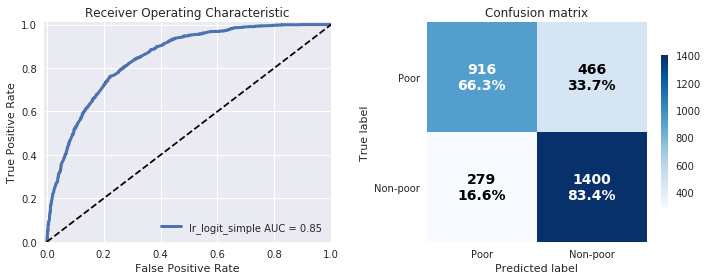

,lr_logit_simple
accuracy,0.756615
recall,0.662808
precision,0.766527
f1,0.710904
cross_entropy,0.483052
roc_auc,0.847086
cohen_kappa,0.502653


Actual poverty rate: 54.11% 
Predicted poverty rate: 50.81% 


In [15]:
# Evaluate performance
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    store_model=True, 
                                    model_name='logit_simple', 
                                    prefix=ALGORITHM_NAME, 
                                    country=COUNTRY, 
                                    model=model, 
                                    features=coefs)

In the first plot above, we show the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). The AUC is the total area under the curve, and is a common general measure of model performance. In this case, we have an AUC of ~84.5%.

A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is another common way to view model results. This lets us see how correctly the model predicts each class compared to the actual values. The accuracy, recall, and precision can all be calculated from the confusion matrix.

Overall, this model does not perform very well, but we are only considering a few features from the dataset. We can probably improve the performace by including more features or finding better parameters for our model.

# Scikit-Learn Logistic Regression <a class="anchor" id="sklearn-logreg"></a>

Scikit-Learn is one of the most popular Python machine learning available. It contains a multitude of powerful tools the makes it an ideal choice for use in production environments. It provides a very robust, standardized API and comprehensive documentation, so once a user becomes familiar with the structure of building models with the package, it is fairly easy to apply it to other models.

For this reason, we will utilize Scikit-Learn throughout the remainder of this project. Most of the algorithms we will introduce have been implemented in Scikit-Learn, and even for those that aren't, we will still leverage the Scikit-Learn data processing and pipeline tools.

Scikit-Learn's [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model incorporates several different methods behind the scenes that help it to perform more reliably with different types of datasets:
* It incorporates a regularization function by default. This helps prevent possible overfitting of the data by penalizing large coefficients. This also helps reduce the issues normally would be caused by multicollinearity, so it handles much of this internally.
* It lets us keep the categorical labels for the dependent variable. 
* It allows us to incorporate sample weights. In the case of poverty prediction, utilizing the sample weights in our model allows us to extrapolate the results to the entire population of a country, which is one of our goals with this project.

First, we load the data like we did before. We do this to prevent any changes that may have occurred earlier in this notebook.

Let's try running the model with the same features we used in the statsmodel implementation so we can directly compare the differences. We can get an initial idea for how well the model performs by running it again on the training data. This is done with the `score` function in sklearn.

CPU times: user 22.5 ms, sys: 0 ns, total: 22.5 ms
Wall time: 22.5 ms
CPU times: user 52.9 ms, sys: 318 ms, total: 371 ms
Wall time: 18.8 ms
In-sample score: 76.39%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


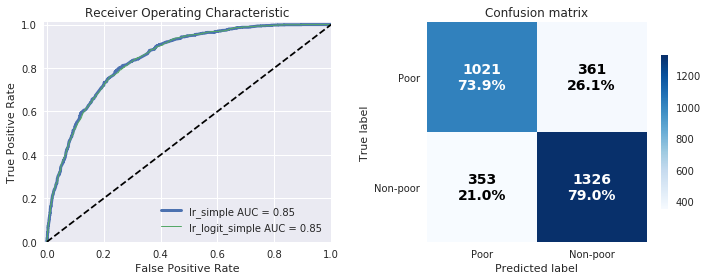

,lr_simple,lr_logit_simple
accuracy,0.766743,0.756615
recall,0.738784,0.662808
precision,0.743086,0.766527
f1,0.740929,0.710904
cross_entropy,0.478969,0.483052
roc_auc,0.847856,0.847086
cohen_kappa,0.528811,0.502653


Actual poverty rate: 54.11% 
Predicted poverty rate: 58.13% 


In [16]:
from sklearn.linear_model import LogisticRegression

# Load and transform the training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)
y_train = np.ravel(y_train)
standardize(X_train)
X_train = X_train[selected_columns]

# Fit the model
model = LogisticRegression()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train[selected_columns], model.coef_[0])

# Load and transform the test set
X_test, y_test, w_test = split_features_labels_weights(TEST_PATH)
y_test = np.ravel(y_test)
standardize(X_test)
X_test = X_test[selected_columns]

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    compare_models='lr_logit_simple',
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=coefs)

Our results are almost the same as with the statsmodels version, so we at least know that the two implementations are comparable. 

### LogisticRegression with all features <a class="anchor" id="logreg-all-feats"></a>
Adding more features may improve the model. Since logistic regression in sklearn is more adept at handling issues related to multicollinearity, we can attempt to run it with the full dataset of features, as well as with the sample weights.

Also, notice that we are repeating some standard operations on the data each time we load it in: standardize X, select the feature columns, and convert y to an array. To ensure we are following the same operations for both test and train data, we can build a customized `load_data` function. Since we'll be using this function in most of the algorithms, we'll add it to the `load_data.py` module as well.

In [17]:
def load_data(path, selected_columns=None, ravel=True, standardize_columns='numeric'):
    X, y, w = split_features_labels_weights(path)
    if selected_columns is not None:
        X = X[[col for col in X.columns.values if col in selected_columns]]
    if standardize_columns == 'numeric':
        standardize(X)
    elif standardize_columns == 'all':
        standardize(X, numeric_only=False)
    if ravel is True:
        y = np.ravel(y)
        w = np.ravel(w)
    return (X, y, w)

CPU times: user 409 ms, sys: 55.5 ms, total: 464 ms
Wall time: 469 ms
CPU times: user 105 ms, sys: 597 ms, total: 703 ms
Wall time: 241 ms
In-sample score: 89.67%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


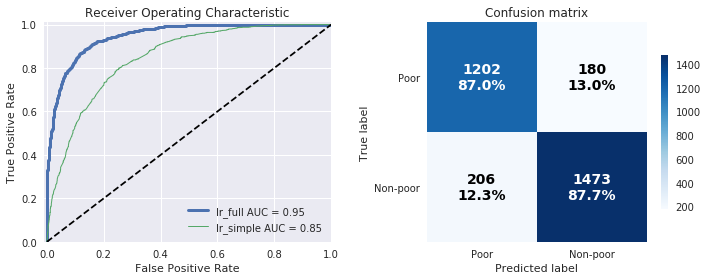

,lr_full,lr_simple
accuracy,0.873897,0.766743
recall,0.869754,0.738784
precision,0.853693,0.743086
f1,0.861649,0.740929
cross_entropy,0.288223,0.478969
roc_auc,0.948658,0.847856
cohen_kappa,0.745821,0.528811


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.11% 


In [18]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LogisticRegression()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, show=True, 
                                    compare_models='lr_simple',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

This is much better! By including all of the features in the model, we've increased the accuracy to about 87%. 

### Include Sample Weights <a class="anchor" id="logreg-sample-weights"></a>
Now let's include the sample weights that were provided with the dataset. This will allow us to extrapolate the results of our model to the entire population of a country and give an estimated poverty rate.

CPU times: user 1.83 s, sys: 17.7 ms, total: 1.84 s
Wall time: 1.84 s
CPU times: user 118 ms, sys: 939 ms, total: 1.06 s
Wall time: 66.6 ms
In-sample score: 90.77%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


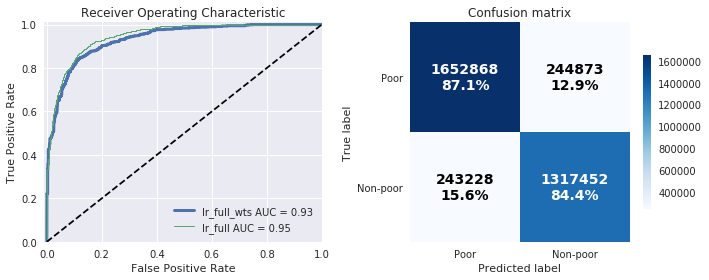

,lr_full_wts,lr_full
accuracy,0.858866,0.873897
recall,0.870966,0.869754
precision,0.871722,0.853693
f1,0.871344,0.861649
cross_entropy,0.365446,0.288223
roc_auc,0.933767,0.948658
cohen_kappa,0.705784,0.745821


Actual poverty rate: 54.11% 
Predicted poverty rate: 54.92% 


In [19]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LogisticRegression()
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])['abs']

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full_wts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

Adding the sample weights has a minor negative effect on the model performance, decreasing accuracy by about 1.5%.

Now that we have a basic model in place, we can attempt to improve its performance through additional techniques to reduce overfitting and tune the parameters.

## Cross-validation <a class="anchor" id="cross-validation"></a>
One common method is to use [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics%29) when fitting the model. Cross-validation divides the training set into a number of different "folds" and fits the model to each. Scikit-Learn includes a variation on the LogisticRegression model that implements cross-validation, called [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). This function utilized stratified k-folds, which means each fold of data contains the same proportion of the response variable in each fold.

## Parameter Tuning <a class="anchor" id="parameter-tuning"></a>
We can also improve model performance by searching for the best parameters. The Scikit-learn LogisticRegression model applies 'l2' [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics%29) by default. The regularization term includes a 'C' parameter that allows us to specify the strength of the regularization, with a smaller 'C' meaning stronger regularization. We can attempt to improve our model results by tuning this parameter. To simplify this process, Scikit-Learn includes a LogisticRegressionCV function that allowing us to search through multiple values for C.

Let's build the model again using LogisticRegressionCV, with 5 cross-validation folds and 10 values of C from 1e-4 to 1e4.

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. In

CPU times: user 4min 5s, sys: 6min 20s, total: 10min 26s
Wall time: 20.4 s
CPU times: user 163 ms, sys: 295 ms, total: 458 ms
Wall time: 14.8 ms
In-sample score: 89.84%
Best model parameters: C=0.0001


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


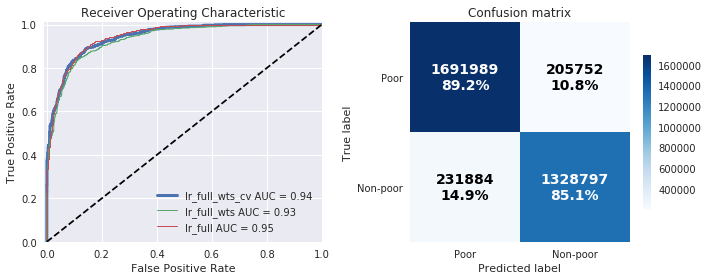

,lr_full_wts_cv,lr_full_wts,lr_full
accuracy,0.873458,0.858866,0.873897
recall,0.891581,0.870966,0.869754
precision,0.87947,0.871722,0.853693
f1,0.885484,0.871344,0.861649
cross_entropy,0.300498,0.365446,0.288223
roc_auc,0.944474,0.933767,0.948658
cohen_kappa,0.734446,0.705784,0.745821


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.49% 


In [20]:
from sklearn.linear_model import LogisticRegressionCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LogisticRegressionCV(Cs=10, cv=5, verbose=1)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])

# Display best parameters
best_params = model.C_[0]
print("Best model parameters: C={}".format(best_params))

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_full_wts', 
                                                    'lr_full'],
                                    store_model=True,
                                    model_name='full_wts_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)
best_model = model

This seems to have helped, raising the accuracy by about 1%. This model performance is much closer to the in-sample score we calculated, and better than the simpler model we first built using only a few features. 

This is our best performing model so far with Logistic Regression, so we'll use it as a baseline for comparison to the other algorithms in this project.

# Feature selection <a class="anchor" id="feature-selection"></a>
Can we do even better using a Logistic Regression Classifier? With only 10 features, our model was about 77% accurate. Using the full survey data, we had a model with *484* features, and the accuracy went up to about 87%. This is a decent improvement, but at what cost? 

Conducting the full surveys takes a significant amount of time and resources for each household. If we could get similar results using much fewer features, it would be more cost and time efficient, and we could actually collect more data by conducting more surveys, which would possibly enable us to train the model for even higher accuracy.

We also mentioned the issue of multicollinearity in the first part of this notebook. If there is a significant amount of collinearity in our training data, it could be negatively affecting the model performance. 

Let's take a deeper look at the features and see if we can improve the model by using a better subset of features and tuning the parameters. 

## Feature selection using top-N coefficients <a class="anchor" id="feature-selection-top-n"></a>
As we discussed before, we can get an idea for the impact each feature has on the model by looking at the coefficients. We could also use these results to filter our features down to a smaller subset. To demonstrate, let's pick the top 40 features from our best model and train the model on these.

Recall that the default regularization for the LogisticRegression model is 'l2'. This type of regularization does not produce a sparse output, so we can expect a non-zero coefficient for each feature.

In [21]:
best_model = evaluation.load_model('lr_full_wts_cv', COUNTRY)
feats = best_model['features'].head(40).index.values
print(feats)

['der_hhsize' 'hld_nbcellpho' 'der_nchild10under' 'cons_0508__Yes'
 'hld_rooms' 'cons_0505__Yes' 'cons_0912__Yes' 'cons_0106__Yes'
 'cons_1101__Yes' 'cons_0504__Yes' 'cons_0410__Yes' 'cons_1108__Yes'
 'cons_0105__Yes' 'cons_0701__Yes' 'cons_0111__Yes' 'cons_0102__Yes'
 'own_528__Yes' 'cons_0907__Yes' 'cons_0205__Yes' 'cons_0803__Yes'
 'cons_0503__Yes' 'cons_0901__Yes' 'cons_0301__Yes' 'cons_0602__Yes'
 'hld_dwelltype__Semi-Permanent' 'cons_0202__Yes' 'cons_0501__Yes'
 'cons_0101__Yes' 'cons_0112__Yes' 'hld_electricity__Yes' 'gifts201__Yes'
 'cons_1103__Yes' 'hld_cooking__Collected firewood' 'cons_1211__Yes'
 'cons_0904__Yes' 'cons_0606__Yes' 'cons_0801__Yes' 'cons_0305__Yes'
 'geo_district__Kasungu' 'cons_1322__Yes']


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished


CPU times: user 7.54 s, sys: 39.4 s, total: 46.9 s
Wall time: 1.54 s
CPU times: user 0 ns, sys: 85.6 ms, total: 85.6 ms
Wall time: 2.78 ms
In-sample score: 86.95%
Best model parameters: C=0.000774263682681127


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


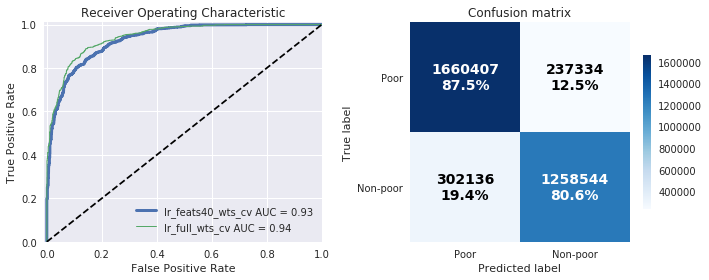

,lr_feats40_wts_cv,lr_full_wts_cv
accuracy,0.844013,0.873458
recall,0.874939,0.891581
precision,0.846049,0.87947
f1,0.860251,0.885484
cross_entropy,0.328352,0.300498
roc_auc,0.932606,0.944474
cohen_kappa,0.683785,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.93% 


In [22]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)

# Fit the model
model = LogisticRegressionCV(Cs=10, cv=5, verbose=1)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])

# Display best parameters
best_params = model.C_[0]
print("Best model parameters: C={}".format(best_params))

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='feats40_wts_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

## Feature selection with iterative elimination <a class="anchor" id="feature-selection-iterative"></a>

Reducing the features gives us a slightly lower performance across most of the metrics. Rather than arbitrarily picking the number of features, we could try to optimize the feature selection by systematically removing features until one of our metrics falls below a desired threshold.

For instance, let's say we want to find the smallest number of features possible while still having the model's `f1` score within 98% of our best model using the full feature set. We'll reduce features one at a time until the `f1` score falls below this threshold. To speed the process up, we can begin by eliminating the lowest coefficients that we are fairly sure have very little impact on the model results.

In [23]:
# initially filter out lowest features
best_model = evaluation.load_model('lr_full_wts_cv', COUNTRY)
coefs = best_model['features']
feats = coefs[coefs['abs'] > 5e-2].index.values

# load metrics from our best model
best_model_metrics = evaluation.load_model_metrics('lr_full_wts_cv', COUNTRY)

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)

# Iteratively drop features until the f1 score is beneath our threshold
max_score = 0
f1_score = 1
cols = X_train.columns
f1_threshold = best_model_metrics['f1'] * 0.98

while (f1_score > f1_threshold) & (X_train.shape[1] >= 1):
    # Fit the model
    model = LogisticRegressionCV(Cs=5)
    model.fit(X_train, y_train, sample_weight=w_train)

    # Get coefficients
    coefs = get_coefs_df(X_train, model.coef_[0]).sort_values('abs', ascending=False)
    feats = coefs.index.values

    # Run the model
    y_pred = model.predict(X_test[X_train.columns])
    y_prob = model.predict_proba(X_test[X_train.columns])[:,1]

    # Evaluate performance
    metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test, show=False)
    
    # Compare f1 score to threshold
    f1_score = metrics['f1']
    if f1_score > max_score:
        max_score = f1_score
        best_feats = X_train.columns
    
    # Drop feature with lowest coefficient
    X_train.drop(feats[-1], axis=1, inplace=True)
    print("n: {}, f1: {}, lowest coef: {}".format(len(feats), metrics['f1'], feats[-1]))
display(coefs)
selected_feats = feats

n: 133, f1: 0.8765075498953188, lowest coef: hld_walls__Compacted earth
n: 132, f1: 0.8786315467357014, lowest coef: hld_credit2__nan
n: 131, f1: 0.878773886724097, lowest coef: hld_rubbish__None
n: 130, f1: 0.8787732082498249, lowest coef: hld_selfscale
n: 129, f1: 0.879497554373612, lowest coef: hld_whynoelec__nan
n: 128, f1: 0.8789087303224425, lowest coef: own_502__Yes
n: 127, f1: 0.8775216115100988, lowest coef: own_516__Yes
n: 126, f1: 0.8779658409686101, lowest coef: hld_adeqhealth__It was more than adequate for household needs
n: 125, f1: 0.8752161082676029, lowest coef: geo_district__Lilongwe City
n: 124, f1: 0.8754462326913729, lowest coef: hld_lighting__Parrafin
n: 123, f1: 0.8763062408027652, lowest coef: cons_1420__Yes
n: 122, f1: 0.874054521486146, lowest coef: cons_0703__Yes
n: 121, f1: 0.874054521486146, lowest coef: inc_101__nan
n: 120, f1: 0.876439663413664, lowest coef: com_bus__Yes
n: 119, f1: 0.8748432606964107, lowest coef: cons_1319__Yes
n: 118, f1: 0.87662979232

,coef_std,coef,abs
der_hhsize,1.456556,1.456636,1.456556
hld_nbcellpho,-0.543518,-0.543548,0.543518
cons_0508__Yes,-0.493950,-1.215371,0.493950
cons_1101__Yes,-0.378966,-1.110765,0.378966
der_nchild10under,0.370059,0.370079,0.370059
hld_rooms,-0.359656,-0.359676,0.359656
cons_1108__Yes,-0.356232,-0.986985,0.356232
cons_0505__Yes,-0.336702,-0.914489,0.336702
cons_0912__Yes,-0.330134,-0.813710,0.330134
cons_0106__Yes,-0.308356,-0.661185,0.308356


This gave us under 60 features, so let's train the model on these and see how it compares

X shape after feature selection:  (9183, 56)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


CPU times: user 10.8 s, sys: 54 s, total: 1min 4s
Wall time: 2.11 s
CPU times: user 7.85 ms, sys: 106 ms, total: 114 ms
Wall time: 3.7 ms
In-sample score: 88.36%
Best model parameters: C=0.0001


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


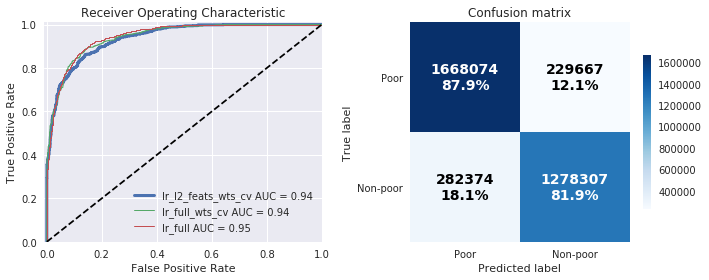

,lr_l2_feats_wts_cv,lr_full_wts_cv,lr_full
accuracy,0.851944,0.873458,0.873897
recall,0.878979,0.891581,0.869754
precision,0.855226,0.87947,0.853693
f1,0.86694,0.885484,0.861649
cross_entropy,0.311735,0.300498,0.288223
roc_auc,0.939074,0.944474,0.948658
cohen_kappa,0.689697,0.734446,0.745821


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.67% 


In [24]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=selected_feats)
print("X shape after feature selection: ", X_train.shape)

# Fit the model
model = LogisticRegressionCV(Cs=10, cv=5, verbose=1)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])

# Display best parameters
best_params = model.C_[0]
print("Best model parameters: C={}".format(best_params))

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=selected_feats)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_full_wts_cv', 
                                                    'lr_full'],
                                    store_model=True,
                                    model_name='l2_feats_wts_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

The resulting model performs slightly worse than our full feature model, but may be good enough to serve our purposes of creating a smaller survey. Let's inspect the consumable features that were selected:

In [25]:
feats = coefs.sort_values('abs', ascending=False).index.values
cons_feats = [x.split('__')[0] for x in feats if x[0:5] == 'cons_']
print("{} consumables features selected:".format(len(cons_feats)))
for x in cons_feats:
    print(questions[x])

38 consumables features selected:
Chicken
Charcoal
Public transport - Bus/Minibus
Goat
Thobwa
Rice
Fresh milk
Beef
Pumpkin
Bread
Green maize
Soft drinks (Coca-cola, Fanta, Sprite, etc.)
Irish potato
Tea
Buns, scones
Cassava flour
Fresh fish
Eggs
Groundnut
Banana
Bean, white
Maize ufa refined (fine flour)
Powdered milk
Cooking oil
Squash (Sobo drink concentrate)
Cigarettes or other tobacco
Small animal - rabbit, mice, etc.
Public transport - Bicycle Taxi
Boy's shoes
Groundnut flour
Girl's dress/skirt
Sugar
Guava
Bicycle service, repair, or parts
Other personal products (shampoo, razor blades, cosmetics, hair products, etc.)
Toothpaste, toothbrush
Matches
Baby nappies/diapers


## Feature Selection using l1 regularization <a class="anchor" id="feature-selection-l1"></a>
We mentioned earlier that the LogisticRegression model applies 'l2' regularization by default. If we apply 'l1' regularization instead, many of the estimated coefficients go to zero. We can select a 'C' value that will set most of the coefficients to zero and use this to reduce the number of features for the model. 

To demonstrate, we'll set $C=3e-5$ and see which features remain.

In [26]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LogisticRegressionCV(cv=5, penalty='l1', Cs=[3e-5] , solver='liblinear')
%time model.fit(X_train, y_train, sample_weight=w_train)
coefs = get_coefs_df(X_train, model.coef_[0])
coefs = coefs[coefs.coef != 0]
print("{} features selected".format(coefs.shape[0]))
display(coefs)
feats = coefs.index.values

CPU times: user 2.41 s, sys: 5.73 s, total: 8.14 s
Wall time: 3 s
87 features selected


,coef_std,coef,abs
der_hhsize,1.100581,1.100641,1.100581
hld_nbcellpho,-0.521397,-0.521426,0.521397
cons_0508__Yes,-0.408605,-1.005377,0.408605
der_nchild10under,0.273294,0.273309,0.273294
cons_0505__Yes,-0.270633,-0.735043,0.270633
hld_rooms,-0.263307,-0.263322,0.263307
cons_1108__Yes,-0.255003,-0.706518,0.255003
cons_0901__Yes,-0.237667,-0.495005,0.237667
cons_0106__Yes,-0.235283,-0.504500,0.235283
cons_0912__Yes,-0.216640,-0.533970,0.216640


Now let's train the model using only these selected features and see how it performs:

CPU times: user 17.9 s, sys: 2min 9s, total: 2min 27s
Wall time: 9.68 s
CPU times: user 21.5 ms, sys: 100 ms, total: 122 ms
Wall time: 7.67 ms
In-sample score: 88.04%
Best model parameters: C=0.0001


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


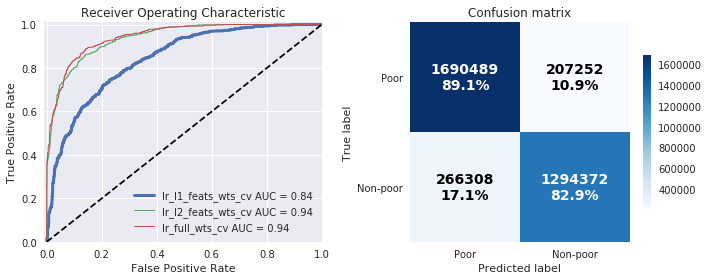

,lr_l1_feats_wts_cv,lr_l2_feats_wts_cv,lr_full_wts_cv
accuracy,0.86307,0.851944,0.873458
recall,0.89079,0.878979,0.891581
precision,0.863906,0.855226,0.87947
f1,0.877142,0.86694,0.885484
cross_entropy,2.04279,0.311735,0.300498
roc_auc,0.842983,0.939074,0.944474
cohen_kappa,0.712446,0.689697,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.73% 


In [27]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)

# Fit the model
model = LogisticRegressionCV(Cs=10, cv=5)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])

# Display best parameters
print("Best model parameters: C={}".format(model.C_[0]))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test[feats])[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_l2_feats_wts_cv', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='l1_feats_wts_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

We could in practice do a similar iterative process as we did with the 'l2' method, but in this case we seem to have a good set of features, with comparable performance to the other method.

Let's look at the list of consumable items that ended up in our final feature selection and see if they make intuitive sense. If we refer back up to the list of coefficients, we note that the sign of nearly all the consumable coefficients is negative, so a "Yes" value for any of these pushes the outcome towards being "non-poor".

In [28]:
cons_feats = [x.split('__')[0] for x in feats if x.startswith('cons_')]
print("{} consumables features selected:".format(len(cons_feats)))
for x in cons_feats:
    print(questions[x])

49 consumables features selected:
Chicken
Goat
Public transport - Bus/Minibus
Tea
Rice
Thobwa
Pumpkin
Green maize
Beef
Buns, scones
Banana
Bread
Eggs
Fresh milk
Charcoal
Soft drinks (Coca-cola, Fanta, Sprite, etc.)
Toothpaste, toothbrush
Irish potato
Cooking oil
Groundnut
Guava
Bean, white
Sugar
Fresh fish
Cassava tubers
Donation - to church, charity, beggar, etc.
Groundnut flour
Small animal - rabbit, mice, etc.
Girl's dress/skirt
Boy's shoes
Men's trousers
Other personal products (shampoo, razor blades, cosmetics, hair products, etc.)
Public transport - Bicycle Taxi
Lady's shoes
Bicycle service, repair, or parts
Cigarettes or other tobacco
Sugar Cane
Bean, brown
Salt
Pork
Lady's dress/skirt
Maize ufa refined (fine flour)
Onion
Smoked fish
Citrus - naartje, orange, etc.
Chitenje cloth
Dried fish
Boy's trousers
Batteries


We now have just under the 50 consumable features we desired. The items on the top of the list appear to make sense. A family that is able to purchase chicken and goat, as well as bus fare may be less likely to be poor. 

# Logistic Regression Malawi Summary <a class="anchor" id="summary"></a>
In this notebook, we have covered the basic concepts of a logistic regression classifier, and applied it to a unique poverty dataset for Malawi. We also introduced two Python machine learning libraries, and explored some techniques for analyzing the performance of our model, tuning parameters, and selecting features. 

In the next notebook, we will apply what we have learned about logistic regression classification to the Indonesia dataset. 

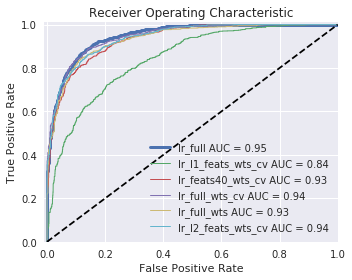

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
lr_full,0.873897,0.869754,0.853693,0.861649,0.288223,0.948658,0.745821,0.00997812
lr_l1_feats_wts_cv,0.86307,0.89079,0.863906,0.877142,2.04279,0.842983,0.712446,0.0161967
lr_feats40_wts_cv,0.844013,0.874939,0.846049,0.860251,0.328352,0.932606,0.683785,0.0181969
lr_full_wts_cv,0.873458,0.891581,0.87947,0.885484,0.300498,0.944474,0.734446,0.0138185
lr_full_wts,0.858866,0.870966,0.871722,0.871344,0.365446,0.933767,0.705784,0.00809115
lr_l2_feats_wts_cv,0.851944,0.878979,0.855226,0.86694,0.311735,0.939074,0.689697,0.0156241


In [29]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)